## Alternating Direction Implicit Scheme
We need to find the solution of the Partial Differential Equation
<!-- Need to learn about latex macros  -->
$$ {\partial{u} \over \partial{t}}  =  {\partial^2{u} \over \partial{x}^2} +{\partial^2{u} \over \partial{y}^2} $$
for $ -1 < x \;, y < 1$
$$ u(x, y, 0) = cos{{{\pi} x}\over 2} cos{{{\pi} y}\over 2}$$ 

$ u = 0$ for $x = \pm 1 $ ,  $ y = \pm 1$

Here $$\partial{x} = \partial{y} = {1 \over 2}$$ and  $$ r = \frac{1}{6} $$ 

----

We introduce a new constant $r$ such that
$$ r = {\nu \over 2} {\partial{t} \over (\partial{x})^2}$$

Here the value of $ \nu = 1 $

$$ \implies r = {1 \over 2} {\partial{t} \over (\partial{x})^2} $$




### Step 1
First we generate the Difference Equation from the implicit scheme wrt  $𝑥$ and explicit scheme wrt $ 𝑦$  from $ 𝑡_𝑛→𝑡_{𝑛+\frac{1}{2}} $ 

Difference Equation 
$$ -r u_{{i-1}{j}}^{n + \frac{1}{2}} + \, (1 + 2r)u_{{i}{j}}^{n + \frac{1}{2}} -r u_{{i+1}{j}}^{n + \frac{1}{2}}  = r u_{{i}{j-1}}^{n } + \, (1 - 2r)u_{{i}{j}}^{n} +r u_{{i}{j+1}}^n $$

### Step 2
First we generate the Difference Equation from the implicit scheme wrt  $y $ and explicit scheme wrt $ x$  from $ 𝑡_{𝑛+\frac{1}{2}} \rightarrow t_{n+1} $

Difference Equation

$$ -r u_{{i}{j-1}}^{n + 1} + \, (1 + 2r)u_{{i}{j}}^{n + 1} -r u_{{i}{j+1}}^{n + 1}  = r u_{{i-1}{j}}^{n + \frac{1}{2}} + \, (1 - 2r)u_{{i}{j}}^{n + \frac{1}{2}} +r u_{{i+1}{j}}^{n + \frac{1}{2}} $$


In [209]:
import numpy as np 
from matplotlib import pyplot as plt 
from mpl_toolkits import mplot3d
from copy import copy
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [210]:
def a(r):
    return -1*r 
def b(r):
    return (1 + 2*r)
def c(r):
    return -1*r

def ThomasAlgorithm(a, b, c, d, n):
    c_dash = np.zeros(n-1)
    d_dash = np.zeros(n-1)
    c_dash[0] = c[0] / b[0]
    d_dash[0] = d[0] / b[0]
    for itr in range(1, n-1):
        c_dash[itr] = c[itr] / (b[itr] - a[itr] * c_dash[itr-1])
        d_dash[itr] = (d[itr] - a[itr]*d_dash[itr-1]) / (b[itr] - a[itr] * c_dash[itr-1])
    
    y = np.zeros(n-1)
    y[n-2] = d_dash[n-2]
    
    for itr in reversed(range(n-2)):
        y[itr] = d_dash[itr] - c_dash[itr] * y[itr+1]
    
    return y

In [211]:
# For the ith x solve the difference equation 
def Difference_Step_1(r, u_prev, space_step_x, space_step_y, u_x0, u_xn):
    u = np.zeros((int(space_step_x ), int(space_step_y )))
    
    for j in range(1, int(space_step_y) -1):
        A = np.array([a(r) for i in range(int(space_step_x - 2))])
        B = np.array([b(r) for i in range(int(space_step_x - 2))])
        C = np.array([c(r) for i in range(int(space_step_x - 2))])
        D = np.array([r*(u_prev[i][j-1] + u_prev[i][j+1]) + (1-2*r)*u_prev[i][j] for i in range(1, int(space_step_x))])
        u[1:-1, j] = ThomasAlgorithm(A, B, C, D, int(space_step_x) - 1)
    
    for i in range(0, int(space_step_x)):
        u[i, 0] = u_x0
        u[i, int(space_step_y) - 1] = u_xn
        
    return u

In [212]:
# For the jth y solve the difference equation
def Difference_Step_2(r, u_prev, space_step_x, space_step_y, u_y0, u_yn):
    u = np.zeros((int(space_step_x), int(space_step_y)))
    
    for i in range(1, int(space_step_x) - 1):
        A = np.array([a(r) for j in range(int(space_step_y - 2))])
        B = np.array([b(r) for j in range(int(space_step_y - 2))])
        C = np.array([c(r) for j in range(int(space_step_y - 2))])
        D = np.array([r*(u_prev[i+1][j] + u_prev[i-1][j]) + (1-2*r)*u_prev[i][j] for j in range(1, int(space_step_y))])
        u[i, 1:-1] = ThomasAlgorithm(A, B, C, D, int(space_step_y) - 1)
    
    for j in range(0, int(space_step_y)):
        u[0, j] =  u_y0
        u[int(space_step_x) - 1, j] = u_yn
    return u


In [213]:
def initialize(space_step_x, space_step_y, x0, y0, xn, yn):
    x_coordinates = np.linspace(x0, xn, space_step_x+1)
    y_coordinates = np.linspace(y0, yn, space_step_y+1)
    u = [[np.cos(np.pi*i/2)*np.cos(np.pi*j/2) for i in x_coordinates] for j in y_coordinates]
    return u

def Solver(r, time_step, space_step_x, space_step_y, boundarypoints, boundaryconditions):
    u = np.array(initialize(space_step_x - 1, space_step_y - 1, boundarypoints[0][0], boundarypoints[1][0], boundarypoints[0][1], boundarypoints[1][1]))
    u_prev = copy(u)
#     print(u.shape)
    Solution = np.reshape(u, (1, u.shape[0], u.shape[1]))
    
    for i in range(int(2*time_step)):
#         print(Solution.shape)
        if(i%2==0):
            u = Difference_Step_1(r, u_prev, space_step_x, space_step_y, boundaryconditions[0][0], boundaryconditions[0][1])
        else:
            u = Difference_Step_2(r, u_prev, space_step_x, space_step_y, boundaryconditions[1][0], boundaryconditions[1][1])
            u_temp = copy(u)
            u_copy = np.reshape(u, (1, u.shape[0], u.shape[1]))
            Solution = np.append(Solution, u_copy, axis=0)
        u_prev = copy(u)
    return Solution

    

In [214]:
x0 = y0 =  -1 
xn = yn = 1
u_x0 = u_xn = u_yn = u_y0 = 0
r = 1/6
t0 = 0
tn = 1
# Space Conditions
boundaryvalues = [[x0, xn], [y0, yn]]
boundaryconditions = [[u_x0, u_xn], [u_y0, u_yn]]
delta_x = delta_y = 0.2

step_x = step_y =  np.ceil((xn - x0)/delta_x) # because yn = xn and x0 = y0
# Time Conditions
delta_t = 2 * r * delta_x**2 
time_step = np.ceil((tn - t0)/delta_t)

print(time_step)

75.0


/Users/apple/anaconda3/envs/env-python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
/Users/apple/anaconda3/envs/env-python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


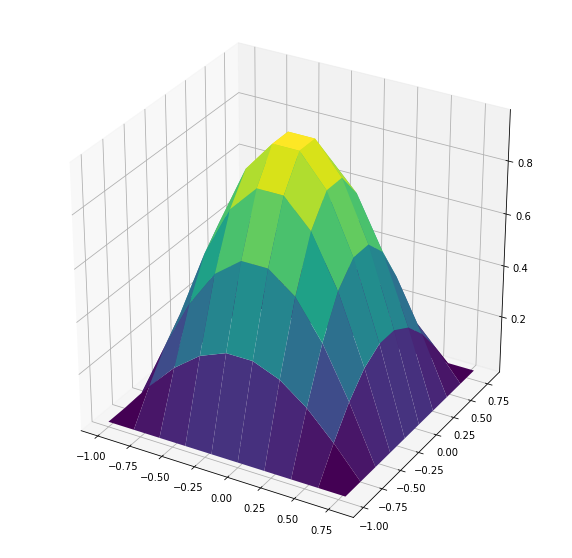

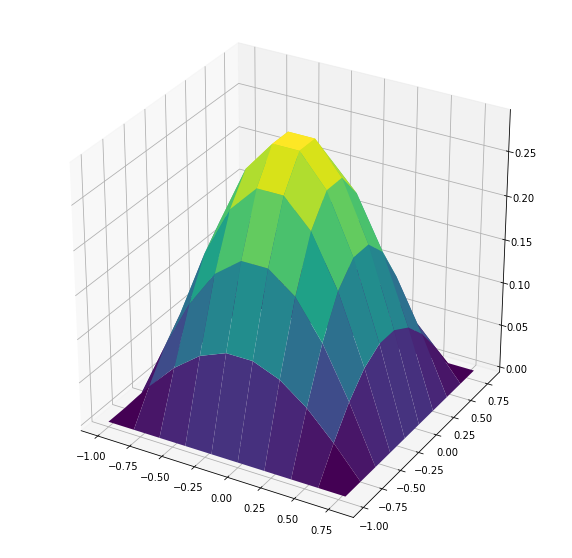

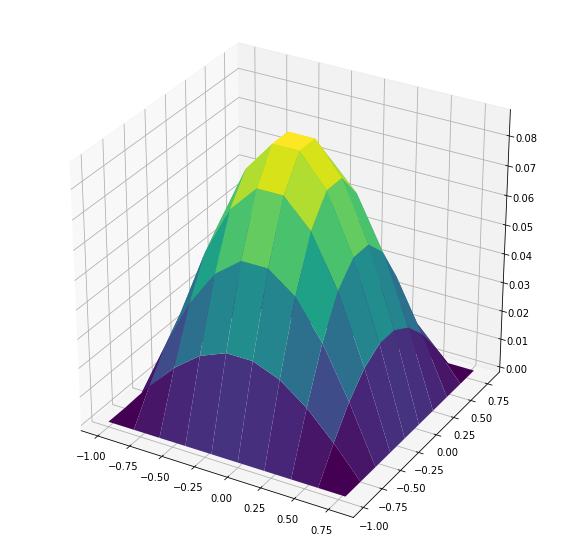

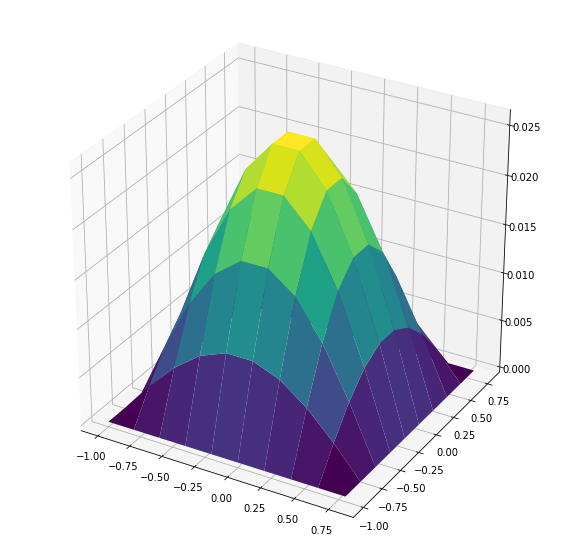

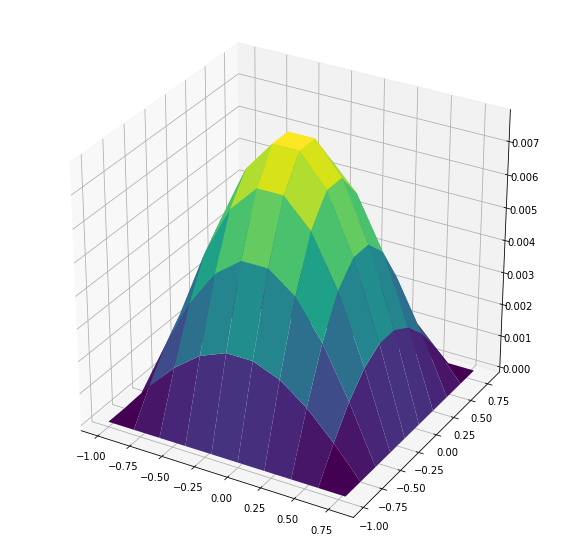

In [215]:
Solution = Solver(r, time_step, step_x, step_y, boundaryvalues, boundaryconditions)
x = np.linspace(x0, xn, step_x + 1)[:-1]
y = np.linspace(y0, yn, step_y+1)[:-1]
for i in range(0, int(time_step), int(time_step/5)):
    u = Solution[i]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, u, cmap='viridis')